# Problem Statement


You will first get a feel for how TKET optimizes and compiles sample circuits for a given backend. You can create a sample circuit of your choice, or you can use some circuits, given as QASM code, [here](https://github.com/spendierk/ethz-hackathon22/tree/main/benchmarking/circuits). Then optimize and run this sample circuit on different backends. Here is a list of questions to get you started:

1. Which gate-based quantum computers are accessible to you to implement your circuit?
1. Which circuit parameters should be minimized for the most efficient circuit implementation for a given backend?
1. What are the main features of TKET, and how can you apply them here?
1. Which backend is the best for a given sample circuit and why?

---

# Solution

Team QBubble: Zhixin Song, Tingting Li, and Yuxuan Yan\
Last update: 08/23/2022

Required Packages:\
qiskit==0.37.1\
pytket==1.5.0 


## 0. Test Case 

For the circuit level compiling, we use `H2JordanWignerMapper.qasm` as a test case. This **4-qubit** circuit contains **56 CNOT gates** and **12 parametrized Rz gates**.


Depth: 83
CNOTS: 56
Rz: 12


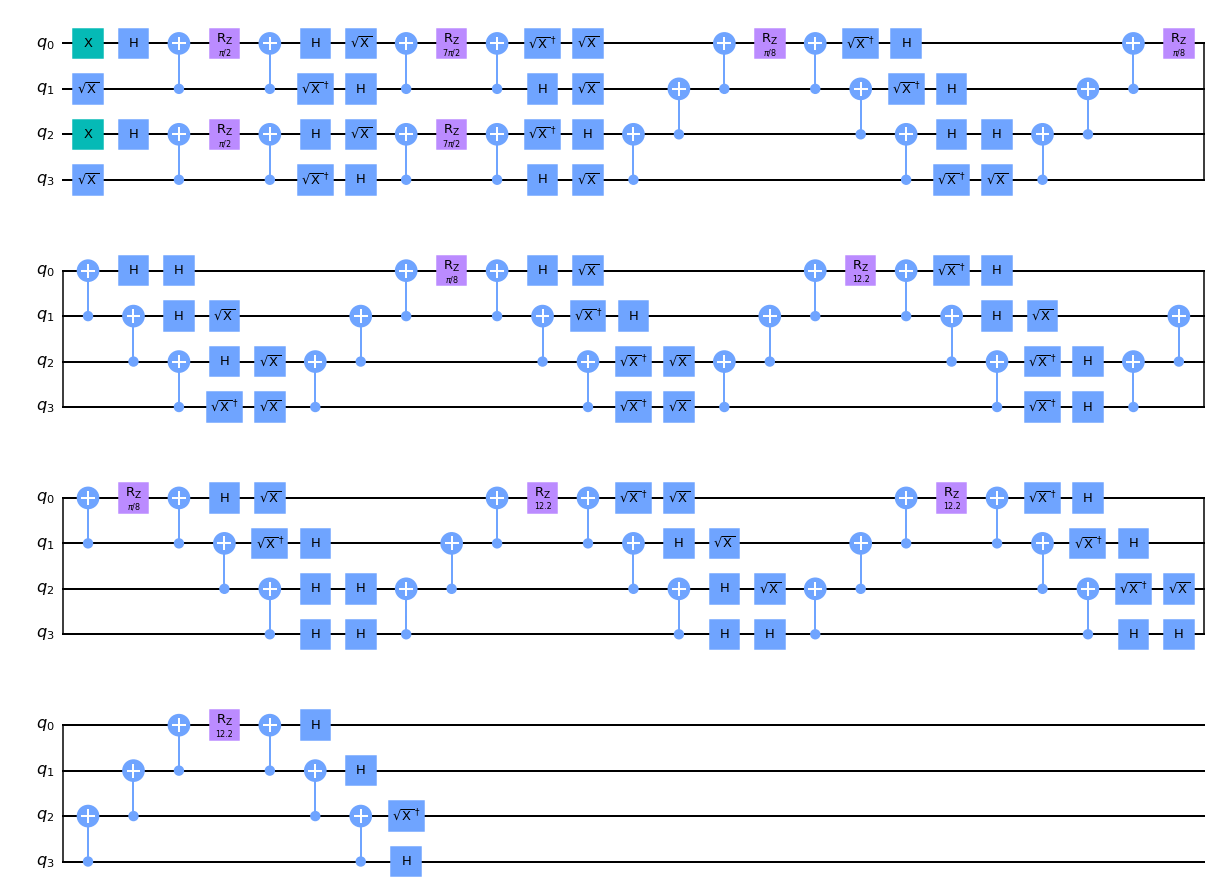

In [11]:
from qiskit import QuantumCircuit

qc = QuantumCircuit.from_qasm_file("H2JordanWignerMapper.qasm")
print("Depth: %i" % qc.depth())
print("CNOTS: %i" % qc.count_ops()['cx'])
print("Rz: %i" % qc.count_ops()['rz'])
qc.draw("mpl")

## 1. Backends

Hardware backends available to our team include: IBMQ and IonQ



## 2. Benchmarks

The goal of compiling is to reduce the effective circuit depth $D$, number of CNOT gates $N_{\text{CNOT}}$, and number of single-qubit parametrized gates $N_{\theta}$. In this case, we will compare the performance of qiskit and pytket compiler under these 3 metrics.

## 3. Qiskit Compiler Results


Before compiling

| Test files  | Width       | Depth $D$  |  $N_{\text{CNOT}}$   | $N_{\theta}$ |
| ----------- | :-----------: |:-----------: | :-----------: | :-----------: |
| H2-JW       | 4-qubit     | 83         | 56         | 12       |


After compiling

| Backends    | Compiler    |Test file   | Qubits      |Optimization level      | $D$     | $N_{\text{CNOT}}$   |$N_{\theta}$   | Fidelity $F$ |
| ----------- | :----------: |:-----------:| :-----------: |:-----------: |:-----------: | :-----------: | :-----------: | :-----------: |
| ibmq_quito  |  Qiskit     | H2-JW      | 5           | 3          | 72      | 37       | 72      | 25.2% (hardware )     |
| ibmq_quito  |  Qiskit     | H2-JW      | 5           | 3          | 72      | 37       | 72      | 50.9% (emulator )     |
| ibmq_belem  |  Qiskit     | H2-JW      | 5           | 3          | 80      | 37       | 71      | 46.2% (emulator )     |
| ibmq_lima   |  Qiskit     | H2-JW      | 5           | 3          | 100     | 37       | 71      | 52.8% (emulator )     |
| ibm_oslo    |  Qiskit     | H2-JW      | 7           | 3          | 80      | 37       | 71      | 65.6% (emulator )     |
| ionq_qpu    |  Qiskit     | H2-JW      | 11          | 3          | 75      | 48       | 14      | 20.3% (hardware)      |


### 3.0 Simulator Result

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


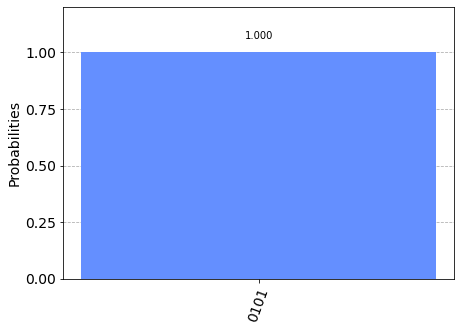

In [3]:
from qiskit import IBMQ, QuantumCircuit, transpile, assemble, Aer, execute
from qiskit.visualization import plot_histogram

# Load circuit from QASM file
qc = QuantumCircuit.from_qasm_file("H2JordanWignerMapper.qasm")
qc.measure_all()

backend_sim = Aer.get_backend("qasm_simulator")
job_sim = backend_sim.run(transpile(qc, backend_sim), shots=1024)
result_sim = job_sim.result()
counts = result_sim.get_counts()
plot_histogram(counts)

### 3.1 Access IBMQ Backends through Qiskit

Optimization Level 0
Depth: 219
Gate counts: OrderedDict([('rz', 172), ('cx', 143), ('sx', 80), ('measure', 4), ('x', 2), ('barrier', 1)])

Optimization Level 1
Depth: 83
Gate counts: OrderedDict([('rz', 58), ('cx', 48), ('sx', 31), ('measure', 4), ('barrier', 1)])

Optimization Level 2
Depth: 83
Gate counts: OrderedDict([('rz', 57), ('cx', 48), ('sx', 31), ('measure', 4), ('barrier', 1)])

Optimization Level 3
Depth: 72
Gate counts: OrderedDict([('rz', 72), ('sx', 45), ('cx', 37), ('measure', 4), ('x', 2), ('barrier', 1)])



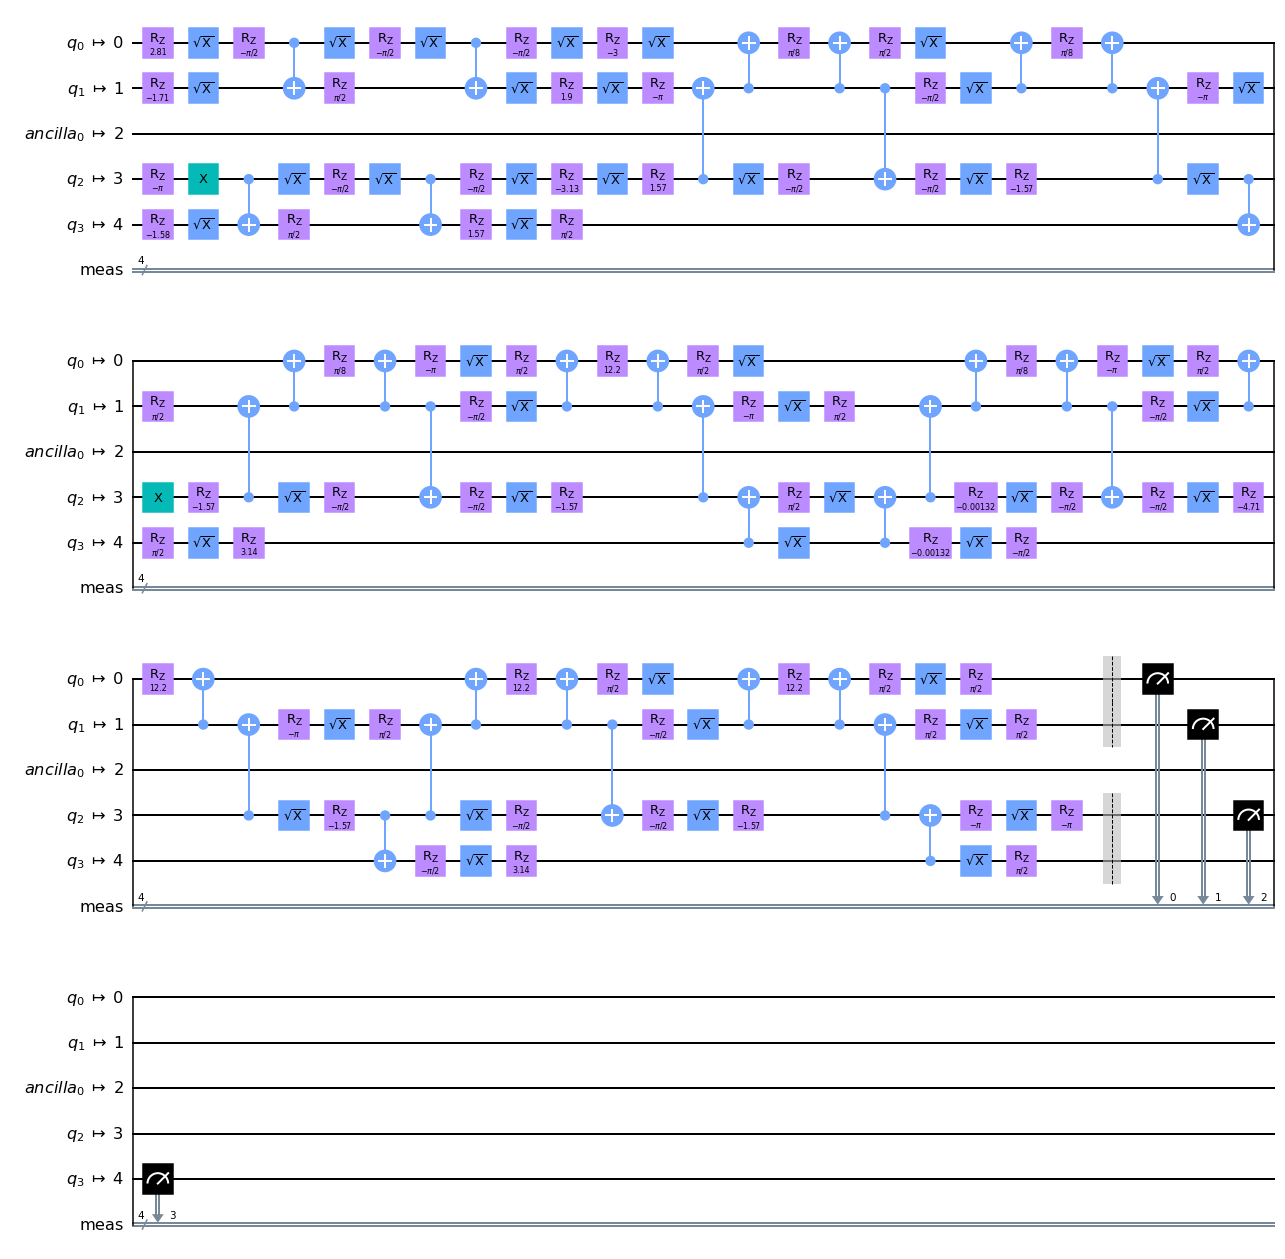

In [4]:
from qiskit import IBMQ, QuantumCircuit, transpile, assemble

# Load circuit from QASM file
qc = QuantumCircuit.from_qasm_file("H2JordanWignerMapper.qasm")
qc.measure_all()

# Load account and get all open-access backends
provider = IBMQ.load_account()

# List all the backends
# print(provider.backends())

# Choose one of the following backends
# backend = provider.get_backend('ibmq_belem')
backend = provider.get_backend('ibmq_quito')
# backend = provider.get_backend('ibmq_lima')
# backend = provider.get_backend('ibmq_manila')
# backend = provider.get_backend('ibmq_jakarta')
# backend = provider.get_backend('ibm_nairobi')
# backend = provider.get_backend('ibm_oslo')

# Hypertune the optimization levels
for lv in range(4):
   circ = transpile(qc, backend, optimization_level=lv)
   print('Optimization Level {}'.format(lv))
   print('Depth:', circ.depth())
   print('Gate counts:', circ.count_ops())
   print()

circ.draw("mpl")

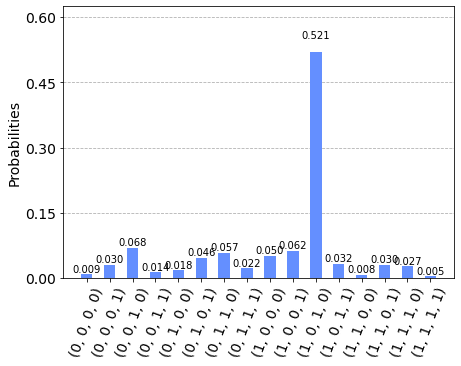

In [5]:
from pytket.extensions.qiskit import qiskit_to_tk, tk_to_qiskit
from pytket.extensions.qiskit import IBMQBackend, IBMQEmulatorBackend
backend = IBMQEmulatorBackend('ibmq_quito')

from qiskit.visualization import plot_histogram
quantum_handle = backend.process_circuit(qiskit_to_tk(circ), n_shots=2048)
quantum_shots = backend.get_result(quantum_handle).get_shots()
counts = backend.get_result(quantum_handle).get_counts()
plot_histogram(counts)

In [1]:
# Code for running on real hardware
# assembled_circuit = assemble(circ, shots=2048)
# res = backend.run(assembled_circuit).result()
# counts = res.get_counts()
# plot_histogram(counts)

### 3.2 Access IonQ Backends through Qiskit

https://ionq.com/docs/get-started-with-qiskit

In [4]:
from IPython.display import clear_output
!pip install qiskit-ionq
clear_output()

Optimization Level 0
Depth: 84
Gate counts: OrderedDict([('cx', 56), ('h', 40), ('sx', 20), ('sxdg', 20), ('rz', 12), ('measure', 4), ('x', 2), ('barrier', 1)])

Optimization Level 1
Depth: 75
Gate counts: OrderedDict([('cx', 48), ('h', 26), ('sx', 13), ('sxdg', 13), ('rz', 12), ('measure', 4), ('ry', 2), ('barrier', 1)])

Optimization Level 2
Depth: 75
Gate counts: OrderedDict([('cx', 48), ('h', 26), ('sx', 13), ('sxdg', 13), ('rz', 12), ('measure', 4), ('ry', 2), ('barrier', 1)])

Optimization Level 3
Depth: 75
Gate counts: OrderedDict([('cx', 48), ('h', 26), ('sx', 13), ('sxdg', 13), ('rz', 12), ('measure', 4), ('ry', 2), ('barrier', 1)])



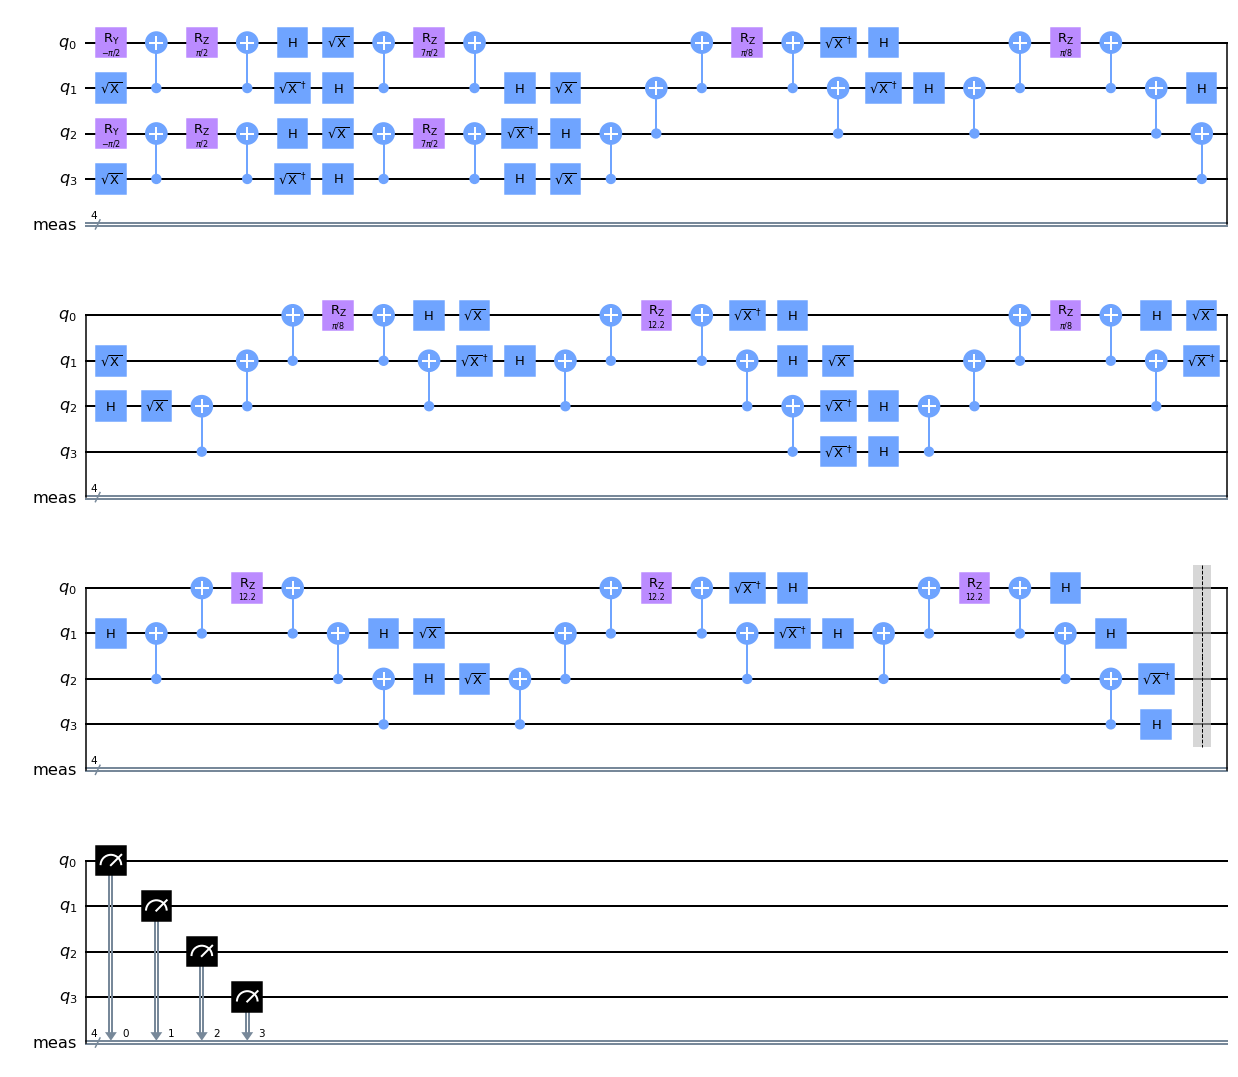

In [6]:
from qiskit_ionq import IonQProvider
from qiskit import QuantumCircuit,transpile

# Load circuit from QASM file
qc = QuantumCircuit.from_qasm_file("H2JordanWignerMapper.qasm")
qc.measure_all()

provider = IonQProvider("private_token")
# backend = provider.get_backend("ionq_qpu.aria-1")
backend = provider.get_backend("ionq_qpu.harmony")


# Hypertune the optimization levels
for lv in range(4):
   circ = transpile(qc, backend, optimization_level=lv)
   print('Optimization Level {}'.format(lv))
   print('Depth:', circ.depth())
   print('Gate counts:', circ.count_ops())
   print()

circ.draw("mpl")

In [7]:
# Code for running on real hardware
qpu_job = backend.run(circ, shots=2048)

from qiskit.providers.jobstatus import JobStatus
import time
# Check if job is done
while qpu_job.status() is not JobStatus.DONE:
    print("Job status is", qpu_job.status() )
    time.sleep(120)

# grab a coffee! This can take up to a few minutes.
# once we break out of that while loop, we know our job is finished
print("Job status is", qpu_job.status() )
print(qpu_job.get_counts()) # these counts are the “true” counts from the actual QPU Run

Job status is JobStatus.INITIALIZING
Job status is JobStatus.DONE
{'0000': 65, '0001': 90, '0010': 82, '0011': 59, '0100': 111, '0101': 416, '0110': 127, '0111': 107, '1000': 95, '1001': 246, '1010': 107, '1011': 191, '1100': 63, '1101': 82, '1110': 136, '1111': 71}


## 4. TKET Compiler Results

Before compiling

| Test files  | Width       | Depth $D$  |  $N_{\text{CNOT}}$   | $N_{\theta}$ |
| ----------- | :-----------: |:-----------: | :-----------: | :-----------: |
| H2-JW       | 4-qubit     | 83         | 56         | 12       |


After compiling

| Backends    | Compiler    |Test file   | Qubits      |Optimization level      | $D$     | $N_{\text{CNOT}}$   |$N_{\theta}$   | Fidelity $F$ |
| ----------- | :----------: |:-----------:| :-----------: |:-----------: |:-----------: | :-----------: | :-----------: | :-----------: |
| ibmq_quito  |  TKET       | H2-JW      | 5           | 2          | 50      | 19       | 23        | 52.4% (hardware)      |
| ibmq_quito  |  TKET       | H2-JW      | 5           | 2          | 50      | 19       | 23        | 58.7% (emulator)      |
| ibmq_belem  |  TKET       | H2-JW      | 5           | 2          | 50      | 19       | 23        | 71.4% (emulator)     |
| ibmq_lima   |  TKET       | H2-JW      | 5           | 2          | 50      | 19       | 23        | 60.7% (emulator)     |
| ibm_oslo    |  TKET       | H2-JW      | 7           | 2          | 58      | 25       | 23        | 61.3% (emulator)     |
| ionq_qpu    | TKET        | H2-JW      | 11          | 2          | 56      | 22       | 60        | 45.2% (harware)     |
|quantinuum.hqs-lt-s1-sim  | TKET  | H2-JW   | 12          | 2          | 56      | 22       | 60        | 92.2% (emulator)     |


### 4.1 Access IBMQ Backends through TKET

In [35]:
from IPython.display import clear_output
!pip install pytket-qiskit
clear_output()

In [2]:
from pytket import Circuit, Qubit, OpType
from pytket.circuit.display import render_circuit_jupyter
from pytket.qasm import circuit_to_qasm, circuit_from_qasm
from pytket.extensions.qiskit import qiskit_to_tk, tk_to_qiskit
from pytket.extensions.qiskit import IBMQBackend, IBMQEmulatorBackend

# Load circuit from QASM file
qasmfile = 'H2JordanWignerMapper.qasm'
qc = circuit_from_qasm(qasmfile)
qc.measure_all()
# print(qc.get_commands())
# render_circuit_jupyter(qc)

# Load account and choose one open-access backends
backend = IBMQEmulatorBackend('ibmq_belem')
# backend.valid_circuit(qc)

# compiled_circ = backend.get_compiled_circuit(qc)
# backend.valid_circuit(compiled_circ )

for ol in range(3):
    compiled_circ = qc.copy()
    backend.default_compilation_pass(ol).apply(compiled_circ)
    assert backend.valid_circuit(compiled_circ)
    print("Optimisation level", ol)
    print("CXs", compiled_circ.n_gates_of_type(OpType.CX))
    print("Rzs", compiled_circ.n_gates_of_type(OpType.Rz))

circ = tk_to_qiskit(compiled_circ)
print('\nDepth:', circ.depth())
print('Gate counts:', circ.count_ops())
# circ.draw("mpl")

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Optimisation level 0
CXs 59
Rzs 83
Optimisation level 1
CXs 51
Rzs 64
Optimisation level 2
CXs 19
Rzs 23

Depth: 50
Gate counts: OrderedDict([('sx', 26), ('rz', 23), ('cx', 19), ('measure', 4), ('x', 1)])


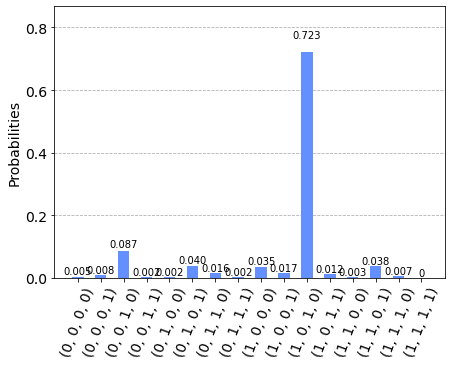

In [3]:
from qiskit.visualization import plot_histogram
quantum_handle = backend.process_circuit(compiled_circ, n_shots=2048)
quantum_shots = backend.get_result(quantum_handle).get_shots()
counts = backend.get_result(quantum_handle).get_counts()
plot_histogram(counts)

In [10]:
# Code for running on real hardware

# from qiskit import IBMQ, QuantumCircuit, transpile, assemble

# provider = IBMQ.load_account()
# backend = provider.get_backend('ibmq_quito')

# assembled_circuit = assemble(circ, shots=2048)
# res = backend.run(assembled_circuit).result()
# counts = res.get_counts()
# plot_histogram(counts)

### 4.2 Access IonQ Backends through TKET

**Please run the following code on Microsoft Azure!!!!**

In [ ]:
from IPython.display import clear_output
!pip install pytket-ionq
clear_output()

In [ ]:
from pytket.extensions.qsharp import AzureBackend
from pytket import Circuit, OpType
from pytket.qasm import circuit_to_qasm, circuit_from_qasm
from pytket.extensions.qiskit import qiskit_to_tk, tk_to_qiskit

backend_ionQ = AzureBackend("ionq.qpu",resourceId="token",location="eastus")

# Load circuit from QASM file
qasmfile = 'H2JordanWignerMapper.qasm'
qc = circuit_from_qasm(qasmfile)
qc.measure_all()
backend_ionQ.valid_circuit(qc)

for ol in range(3):
    compiled_circ = qc.copy()
    backend_ionQ.default_compilation_pass(ol).apply(compiled_circ)
    assert backend_ionQ.valid_circuit(compiled_circ)
    print("Optimisation level", ol)
    print("CXs", compiled_circ.n_gates_of_type(OpType.CX))
    print("Rzs", compiled_circ.n_gates_of_type(OpType.Rz))

circ = tk_to_qiskit(compiled_circ)
print('\nDepth:', circ.depth())
print('Gate counts:', circ.count_ops())

In [10]:
from qiskit.visualization import plot_histogram
quantum_handle = backend_ionQ.process_circuit(compiled_circ, n_shots=2048)
counts = backend_ionQ.get_result(quantum_handle).get_counts()
plot_histogram(counts)

### 4.3 Access Quantinuum Backends through TKET

**Please run the following code on Microsoft Azure!!!!**

https://cqcl.github.io/pytket-quantinuum/api/

In [10]:
from IPython.display import clear_output
!pip install pytket-quantinuum
clear_output()

In [ ]:
from pytket.extensions.qsharp import AzureBackend
from pytket import Circuit, OpType
from pytket.qasm import circuit_to_qasm, circuit_from_qasm
from pytket.extensions.qiskit import qiskit_to_tk, tk_to_qiskit

backend_Q = AzureBackend("quantinuum.hqs-lt-s1-sim",resourceId="token",location="westus")

# Load circuit from QASM file
qasmfile = 'H2JordanWignerMapper.qasm'
qc = circuit_from_qasm(qasmfile)
qc.measure_all()
backend_Q.valid_circuit(qc)

for ol in range(3):
    compiled_circ = qc.copy()
    backend_Q.default_compilation_pass(ol).apply(compiled_circ)
    assert backend_Q.valid_circuit(compiled_circ)
    print("Optimisation level", ol)
    print("CXs", compiled_circ.n_gates_of_type(OpType.CX))
    print("Rzs", compiled_circ.n_gates_of_type(OpType.Rz))

circ = tk_to_qiskit(compiled_circ)
print('\nDepth:', circ.depth())
print('Gate counts:', circ.count_ops())

In [ ]:
from qiskit.visualization import plot_histogram
quantum_handle = backend_Q.process_circuit(compiled_circ, n_shots=2048)
counts = backend_Q.get_result(quantum_handle).get_counts()
plot_histogram(counts)

## 5. Conclusion

We only use the default compiler settings for both qiskit and tket for fair compaison. From the above 2 tables, we can conclude that `Quantinuum H1-1 Emulator` with `TKET compiler` gives the best result. It contains a realtive low cost on CNOT gates $N_{\text{CNOT}}=22$ and highest Fidelity $F = 92.2\%$.

In [16]:
import qiskit.tools.jupyter
%qiskit_version_table